#Importo le librerie e i pacchetti necessari

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

!pip install pmdarima
import pmdarima

# time series analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #per me non servono!!
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess

import warnings
warnings.filterwarnings('ignore')

# Definisco alcune funzioni

In [ ]:
def adf_test(timeseries):
  '''
  ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. 
  The null and alternate hypothesis of this test are:
  Null Hypothesis: The series has a unit root.
  Alternate Hypothesis: The series has no unit root.
  If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.
  '''
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

In [ ]:
def kpss_test(timeseries):
  '''
  KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
  Null Hypothesis: The process is trend stationary.
  Alternate Hypothesis: The series has a unit root (series is not stationary).
  '''
  print ('Results of KPSS Test:')
  kpsstest = kpss(timeseries, regression='c')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
  print (kpss_output)

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def make_model(p, d, q, P, D, Q, x_train, x_val):
  model = sm.tsa.statespace.SARIMAX(train['Value'],
                                    order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                    exog=x_train,
                                    enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit(disp=0, low_memory=True)
  print('SARIMA({},{},{})({},{},{})24 with AIC:{}'.format(p, d, q, P, D, Q, round(model.aic, 0)))
  
  min=model.loglikelihood_burn
  # predict on TRAIN
  predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
  predicted_train_mean = predicted_train.predicted_mean
  residui_train=train['Value'][min:]-predicted_train_mean

  # predict on VALIDATION
  predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1], exog=x_val)
  predicted_val_mean = predicted_val.predicted_mean
  residui_val=validation['Value']-predicted_val_mean

  print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
  print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean),'\n')
  return (predicted_train_mean, predicted_val_mean, residui_train, min)

In [ ]:
def make_model_log(p, d, q, P, D, Q, x_train, x_val):
  model = sm.tsa.statespace.SARIMAX(np.log(train['Value']),
                                    order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                    exog=x_train,
                                    enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit(disp=0, low_memory=True)
  print('SARIMA({},{},{})({},{},{})24 with AIC:{}'.format(p, d, q, P, D, Q, round(model.aic, 0)))

  min=model.loglikelihood_burn
  #predict on TRAIN
  predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
  predicted_train_mean = np.exp(predicted_train.predicted_mean)
  residui_train=train['Value'][min:]-predicted_train_mean

  # predict on VALIDATION
  predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1], exog=x_val)
  predicted_val_mean = np.exp(predicted_val.predicted_mean)
  residui_val=validation['Value']-predicted_val_mean

  print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
  print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean),'\n')
  return (predicted_train_mean, predicted_val_mean, residui_train, min)

In [ ]:
def plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min):
  # prediction on TRAIN
  plt.figure(figsize=(25, 7))
  plt.title('Prediction on TRAIN')
  plt.plot(train['Value'][min:], color='dimgrey', label='Real')
  plt.plot(predicted_train_mean[min:], color='darkred', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['Value'], color='dimgrey', label='Train')
  plt.plot(validation['Value'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['Value'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['Value'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['Value'][2000:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[2000:], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

# Importo i dati

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/streaming data management/progetto')

Mounted at /content/drive


In [ ]:
data_info=pd.read_csv('data_info.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data_info.set_index('Date_Hour', inplace=True)

In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)
data.index.freq='H'

In [ ]:
#Train / validation split
train=data.loc[:"2020-04-30 23:00:00"]
validation=data.loc["2020-05-01 00:00:00":]

#Stazionarietà
Uno dei requisiti per i modelli ARIMA è che le serie temporali siano stazionarie. Una serie è stazionaria se le sue proprietà non cambiano nel tempo. 

Trasformazioni come i logaritmi possono aiutare a stabilizzare la varianza di una serie temporale. La differenza può aiutare a stabilizzare la media di una serie temporale.
Esistono diversi metodi per verificare la stazionarietà di una serie, tra cui il test di Ljung-Box, il Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, il test Augmented Dickey-Fuller.

- **trasformazione Box-Cox**

Osservando i dati, non si nota a colpo d'occhio una non stazionarietà in varianza. 
Proviamo a vedere la relazione tra le medie e le deviazioni standard giornaliere:

In [ ]:
pivot=data_info.pivot_table(index='Date', values='Value', aggfunc=['mean', 'std'])

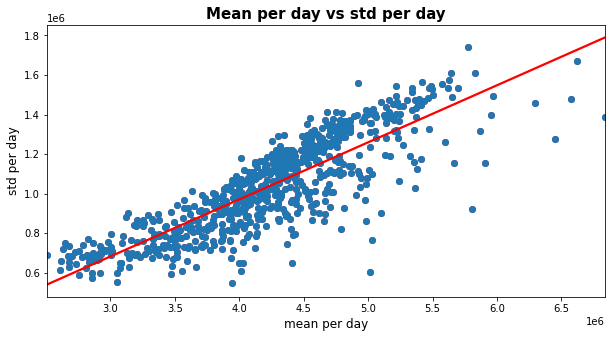

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pivot['mean'], pivot['std'], 'o')
plt.title('Mean per day vs std per day', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
sns.regplot(x='mean', y='std', data=pivot, ci=None, color='red')
plt.ylabel('std per day', fontsize = 12)
plt.xlabel('mean per day', fontsize = 12)
plt.show()

Poichè la relazione tra media e deviazione standard è approssimativamente lineare allora la trasformazione logaritmica è in grado di rendere la serie storica stazionaria in varianza.
Il miglior modo per capire se la trasformazione logaritmica è necessaria è verificare quale modello, quello con o senza trasformazione risulta migliore.
Costruiro quindi dei modelli con e senza trasformazione e sceglierò quello migliore.

- **ADF e KPSS test**

In [ ]:
#The ADF tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.
adf_test(train['Value'])

Results of Dickey-Fuller Test:
Test Statistic                -5.810651e+00
p-value                        4.409576e-07
Lags Used                      4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [ ]:
#The KPSS tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.
kpss_test(train['Value'])

Results of KPSS Test:
Test Statistic            9.070323
p-value                   0.010000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In base al livello di significatività di 0,05 e al p-value del test ADF, l'ipotesi nulla è rifiutata. Quindi, la serie è stazionaria secondo il test ADF.
Sulla base del livello di significatività di 0,05 e del p-value del test KPSS, ci sono prove per rifiutare l'ipotesi nulla a favore dell'alternativa. Quindi la serie non è stazionaria secondo il test KPSS.

Poichè KPSS indica non stazionarietà e ADF indica stazionarietà, la serie è stazionaria per differenza. Quindi applico una differenza per rendere le serie stazionaria.

RIFERIMENTI:
https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

### Applico una differenza stagionale

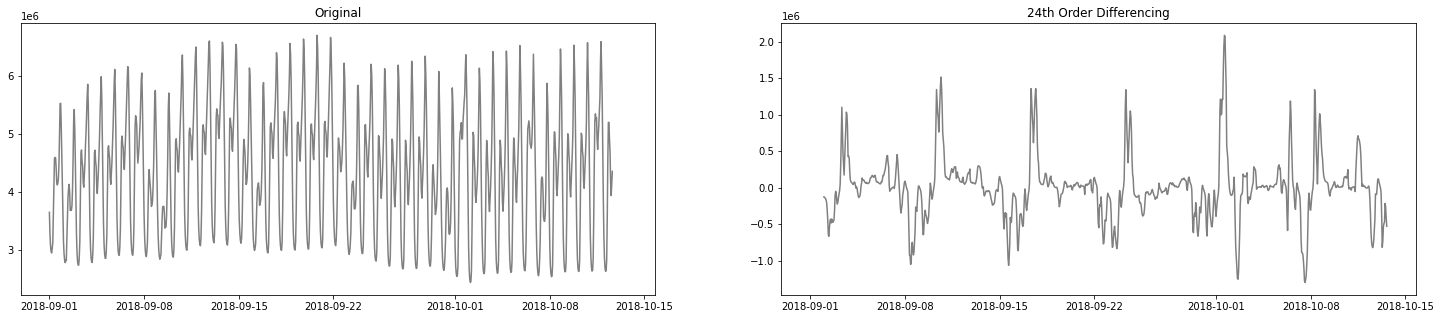

In [ ]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig0, axes0 = plt.subplots(1, 2, sharex=True)

axes0[0].plot(train['Value'][:1000], color = 'gray')
axes0[0].set_title('Original')

axes0[1].plot(train['Value'].diff(24).dropna()[:1000], color = 'gray');
axes0[1].set_title('24th Order Differencing')
plt.show()

In [ ]:
#The ADF tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.
adf_test(train['Value'].diff(24).dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -22.449561
p-value                            0.000000
Lags Used                         42.000000
Number of Observations Used    14525.000000
Critical Value (1%)               -3.430800
Critical Value (5%)               -2.861739
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
#The KPSS tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.
kpss_test(train['Value'].diff(24).dropna())

Results of KPSS Test:
Test Statistic            0.018266
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Sulla base del p-value del test ADF, rifiuto l'ipotesi nulla a favore dell'alternativa.
In base al valore p del test KPSS, l'ipotesi nulla non può essere rifiutata. Quindi, la serie è ora stazionaria per entrambi i test.

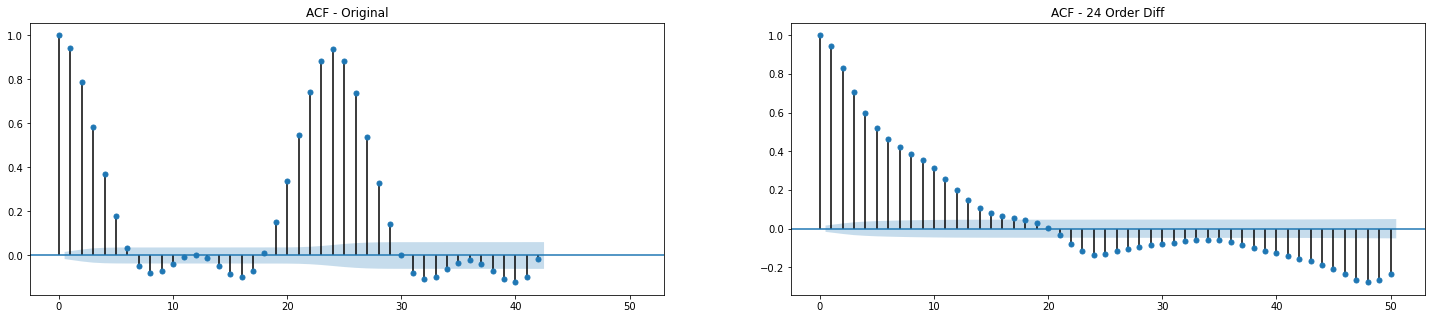

In [ ]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(train['Value'], ax=axes1[0])
axes1[0].set_title('ACF - Original')
plot_acf(train['Value'].diff(24).dropna(), ax=axes1[1], lags=50)
axes1[1].set_title('ACF - 24 Order Diff')
plt.show()

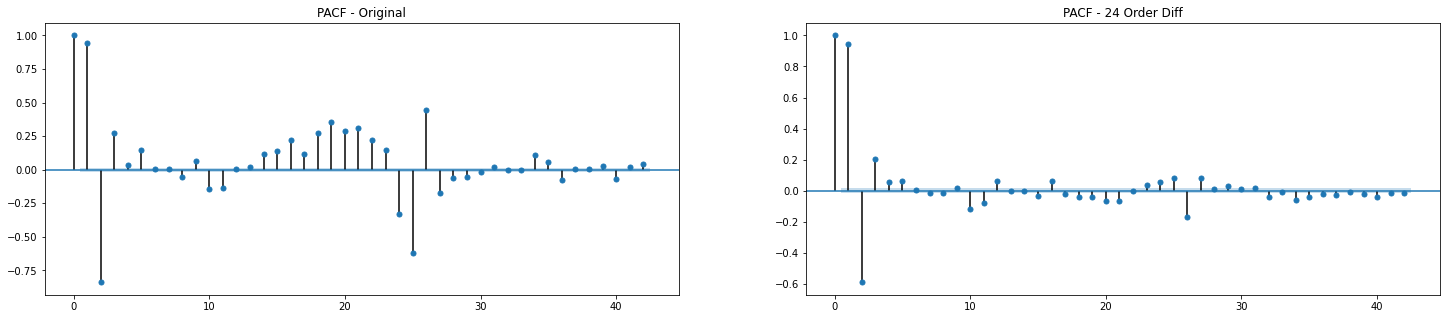

In [ ]:
fig2, axes2 = plt.subplots(1, 2, sharex=True)
plot_pacf(train['Value'], ax=axes2[0])
axes2[0].set_title('PACF - Original')
plot_pacf(train['Value'].diff(24).dropna(), ax=axes2[1])
axes2[1].set_title('PACF - 24 Order Diff')
plt.show()

In [ ]:
print('numero diff semplici, KPSS test', pmdarima.arima.ndiffs(train['Value'].diff(24).dropna(), test='kpss'))
print('numero diff semplici, ADF test', pmdarima.arima.ndiffs(train['Value'].diff(24).dropna(), test='adf'))

numero diff semplici, KPSS test 0
numero diff semplici, ADF test 0


Possiamo riassumere che:
-  Il test KPSS mostra che i dati iniziali sono stazionari, ADF invece che non sono stazionari. Come mostra il plot dell'ACF, i dati presentano una stagionalità ogni 24 ore.
- Una volta applicata una differenza stagionale, i test sono concordanti nell'affermare che la serie così ottenuta è stazionaria.
-Mi sono domandata se avesse senso applicare un'ulteriore differenza semplice. Nonostante i grafici 'ACF - 24 Order Diff' e 'PACF - 24 Order Diff' mostrano ancora della stagionalità nei dati, tutti i test provati (KPSS, ADF) sono concordi nell'affermare di non applicare differenze semplici oltre a quella stagionale.
Decido quindi di applicare una sola differenza stagionale.
- Il grafico 'PACF - 24 Order Diff' mostra che potrebbe essere buono un ordine p=1 o p=2, P=1, Q=1.

# Modello SARIMA in forma state space
Per determinare i migliori parametri non stagionali, p e q, uso un approccio grid search. Costruisco i modelli sia con i dati che con quelli log-trasformati. Per fare ciò utilizzo le funzioni make_model e  make_model_log precedentemente definite.

In [ ]:
for p in range(3): 
  for q in range(3):
    _=make_model(p, 0, q, 1, 1, 1, None, None)

SARIMA(0,0,0)(1,1,1)24 with AIC:417218.0
MAE train: 276458.0
MAE validation: 716203.0 

SARIMA(0,0,1)(1,1,1)24 with AIC:406377.0
MAE train: 157702.5
MAE validation: 710287.1 

SARIMA(0,0,2)(1,1,1)24 with AIC:400669.0
MAE train: 110341.7
MAE validation: 707535.0 

SARIMA(1,0,0)(1,1,1)24 with AIC:383424.0
MAE train: 84912.7
MAE validation: 718818.9 

SARIMA(1,0,1)(1,1,1)24 with AIC:378389.0
MAE train: 69836.8
MAE validation: 711543.9 

SARIMA(1,0,2)(1,1,1)24 with AIC:377501.0
MAE train: 66466.6
MAE validation: 710414.0 

SARIMA(2,0,0)(1,1,1)24 with AIC:377707.0
MAE train: 67167.6
MAE validation: 713421.9 

SARIMA(2,0,1)(1,1,1)24 with AIC:377324.0
MAE train: 65770.2
MAE validation: 711881.0 

SARIMA(2,0,2)(1,1,1)24 with AIC:377291.0
MAE train: 65584.2
MAE validation: 711547.3 



In [ ]:
for p in range(3): 
  for q in range(3):
    _=make_model_log(p, 0, q, 1, 1, 1, None, None)

SARIMA(0,0,0)(1,1,1)24 with AIC:-29681.0
MAE train: 274785.7
MAE validation: 726388.8 

SARIMA(0,0,1)(1,1,1)24 with AIC:-46611.0
MAE train: 152181.4
MAE validation: 726320.8 

SARIMA(0,0,2)(1,1,1)24 with AIC:-57133.0
MAE train: 104576.2
MAE validation: 726938.0 

SARIMA(1,0,0)(1,1,1)24 with AIC:-63294.0
MAE train: 82676.4
MAE validation: 726202.6 

SARIMA(1,0,1)(1,1,1)24 with AIC:-68421.0
MAE train: 66682.4
MAE validation: 727167.8 

SARIMA(1,0,2)(1,1,1)24 with AIC:-69288.0
MAE train: 63291.2
MAE validation: 727247.9 

SARIMA(2,0,0)(1,1,1)24 with AIC:-68910.0
MAE train: 64429.8
MAE validation: 726196.4 

SARIMA(2,0,1)(1,1,1)24 with AIC:-69326.0
MAE train: 62807.1
MAE validation: 726737.0 

SARIMA(2,0,2)(1,1,1)24 with AIC:-69379.0
MAE train: 62564.1
MAE validation: 726840.6 



La trasformazione logaritmica non sembra migliorare, in termini di MAE i modelli. Decido quindi di non applicare una trasformazione logaritmica ai dati. Il miglior modello fin'ora sembra essere quello SARIMA(2,0,2)(1,1,1)24.

In [ ]:
predicted_train_mean, predicted_val_mean, residui_train, min= make_model(2, 0, 2, 1, 1, 1, None, None)

SARIMA(2,0,2)(1,1,1)24 with AIC:377291.0
MAE train: 65584.2
MAE validation: 711547.3 



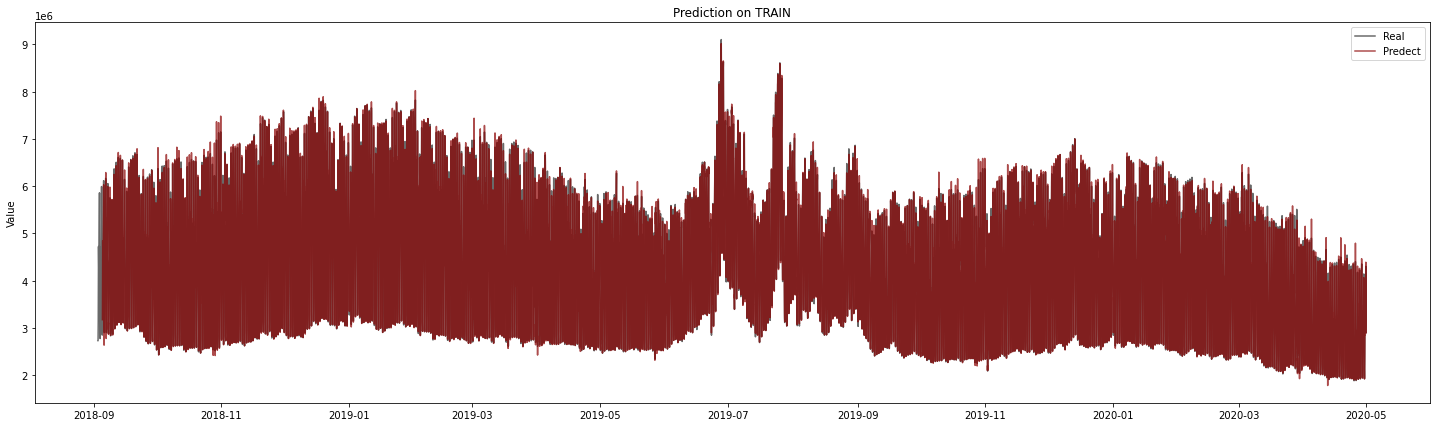

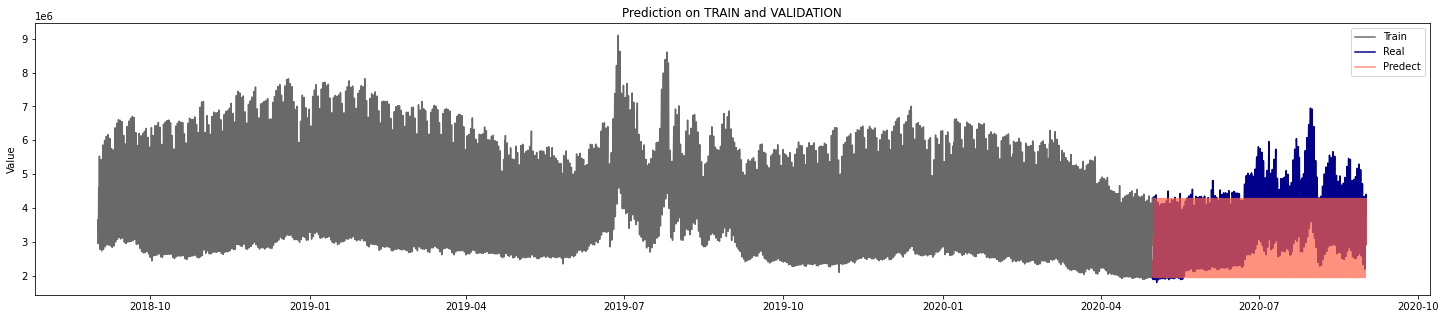

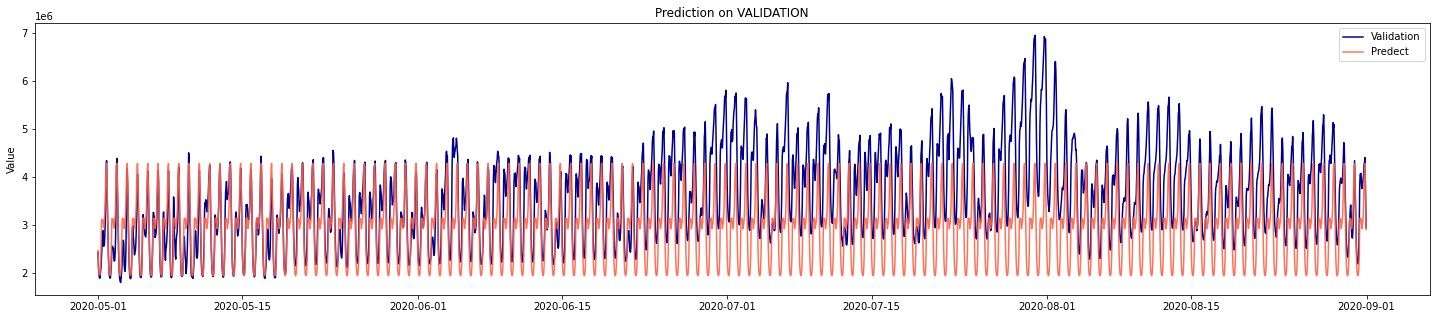

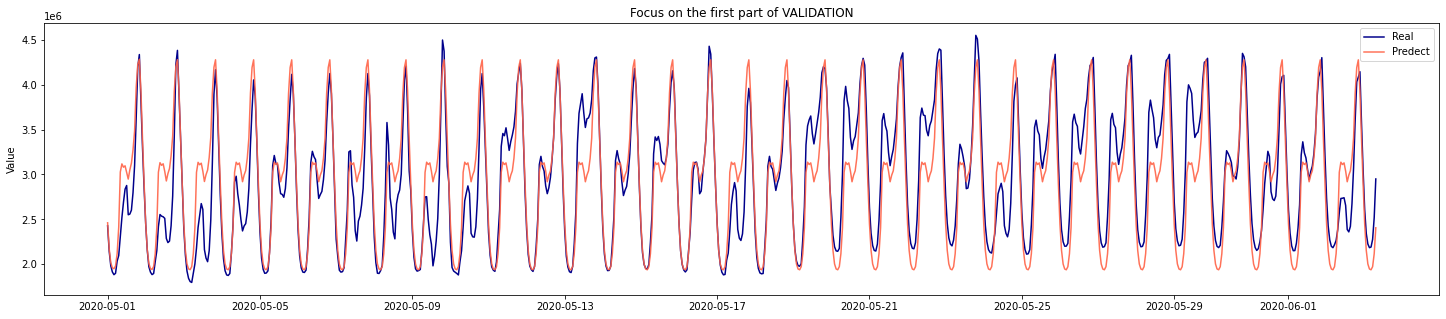

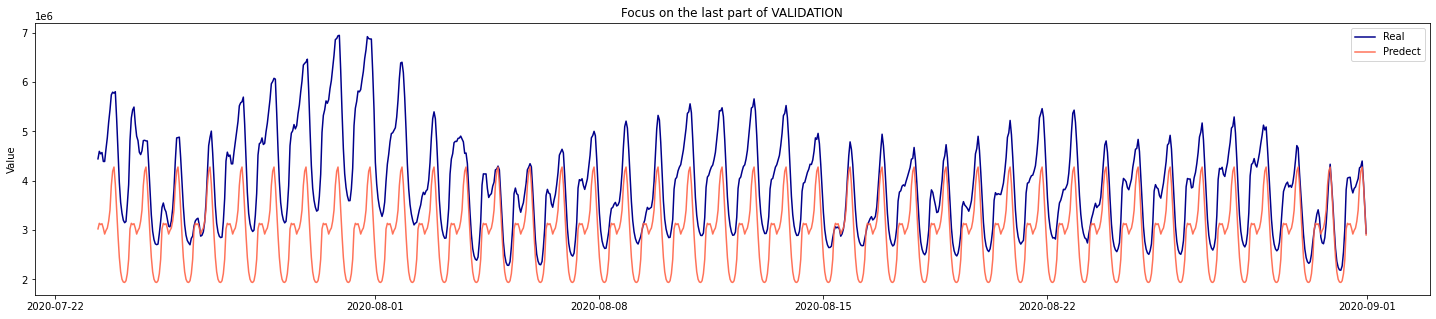

In [ ]:
plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min)

Come si vede dal grafico, che rappresenta le previsioni sul validation set, il modello ha colto la stagionalità giornaliera. Non considera però la stagionalità infrasettimanale, annua e il fattore covid.

# Modello SARIMAX in forma state space


Per far fronte alla stagionalità multipla, è necessario aggiungere regressori esterni al modello SARIMA. Inserisco quindi delle variabili stagionali costruite tramite serie di Fourier con periodo 168 (settimanale) e 8766=24*365.25 (annuale).   

In [ ]:
for a in range(10, 20, 5):
  for b in range(5, 30, 5):
    four_sett = DeterministicProcess(data.index,  period=168, fourier=a)
    four_ann = DeterministicProcess(data.index,  period=24*365.25, fourier=b)
    print("weekly fourier armonics: {}, annual fourier armonics: {}" .format(a, b))
    four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

    x_train=four[:len(train)]
    x_val=four[len(train):]

    _=make_model(2, 0, 2, 1, 1, 1, x_train, x_val)
#it's very slow!!!!!!!

Aggiungo infine la variabile step 'covid' precedentemente costruita. Non si hanno miglioramenti in termini di MAE (MAE train: 81200.8, MAE validation: 384351.2)

In [ ]:
#fourier's harmonics
four_sett = DeterministicProcess(data.index,  period=168, fourier=10)
four_ann = DeterministicProcess(data.index,  period=24*365.25, fourier=5)
four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

In [ ]:
x_train=four[:len(train)]
x_val=four[len(train):]
x_train['covid']=data_info['covid'][:len(train),]
x_val['covid']=data_info['covid'][len(train):,]

_=make_model(2, 0, 2, 1, 1, 1, x_train, x_val)

Il modello migliore scelto è quindi SARIMA(1,0,1)(1,1,1)24 con con 10 armoniche per la stagionalità settimanale e 5 per quella annuale e senza la variabile covid.  Analizzo la sua bontà.

In [ ]:
x_train=four[:len(train)]
x_val=four[len(train):]

predicted_train_mean, predicted_val_mean, residui_train, min= make_model(2, 0, 2, 1, 1, 1, x_train, x_val)

SARIMA(2,0,2)(1,1,1)24 with AIC:197697374.0
MAE train: 308301.8
MAE validation: 334117.9 



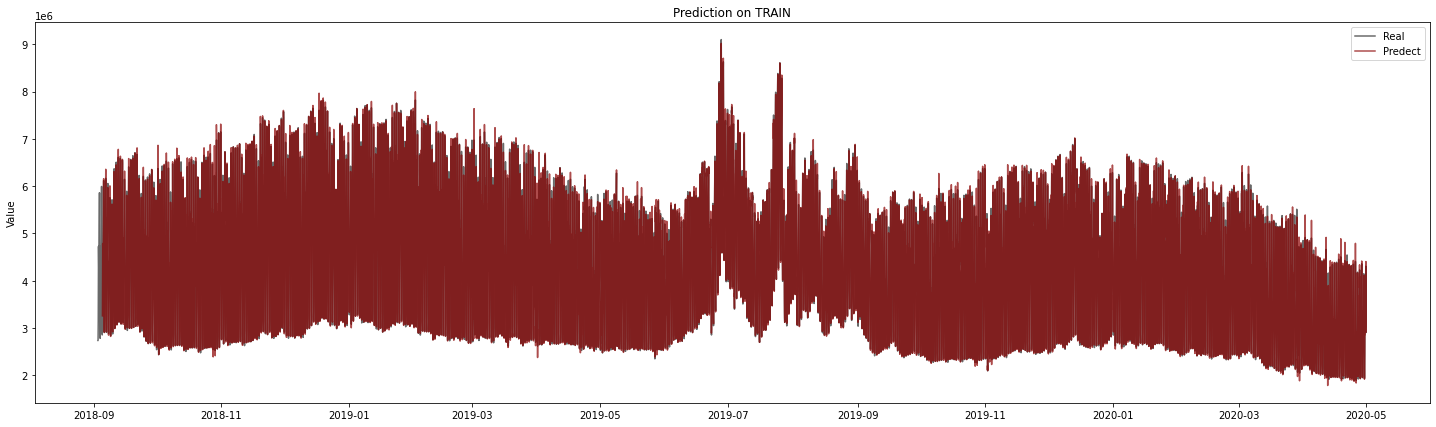

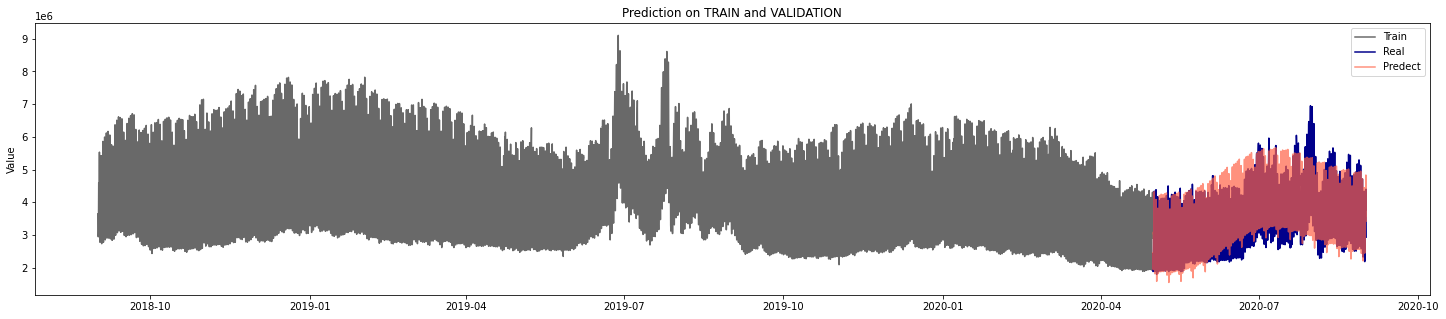

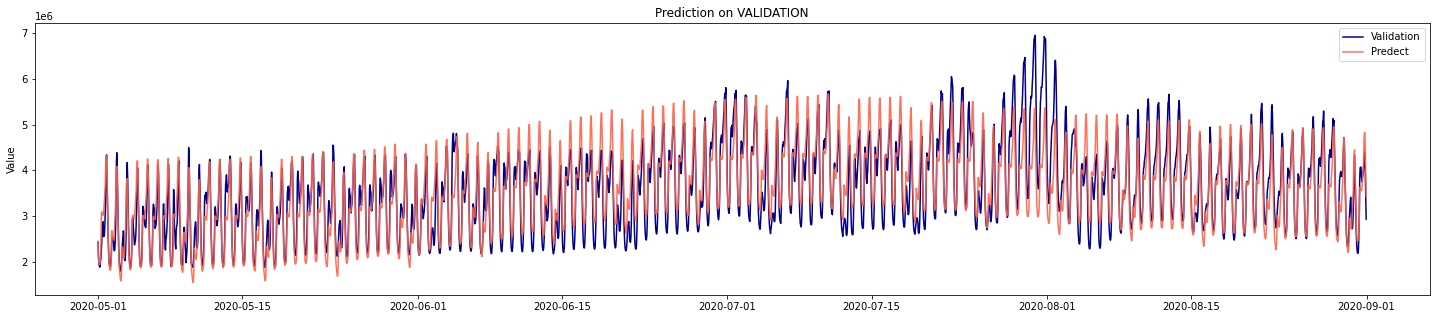

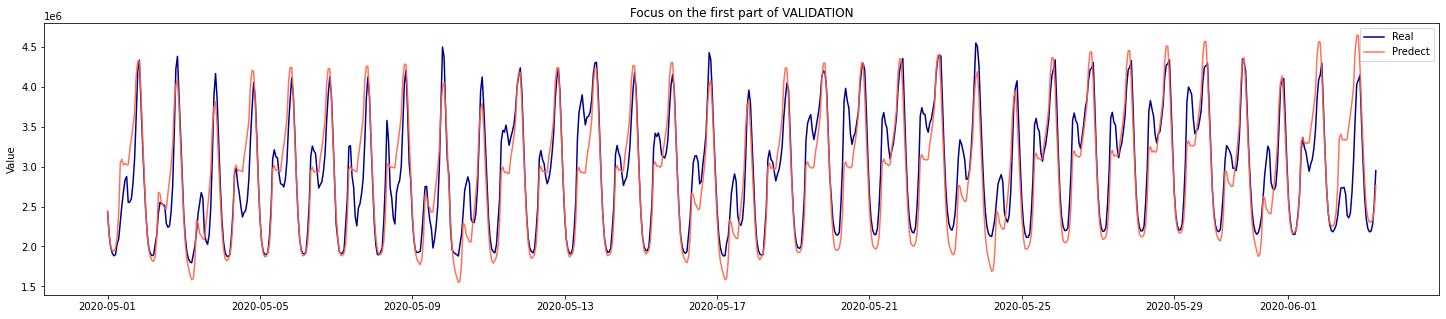

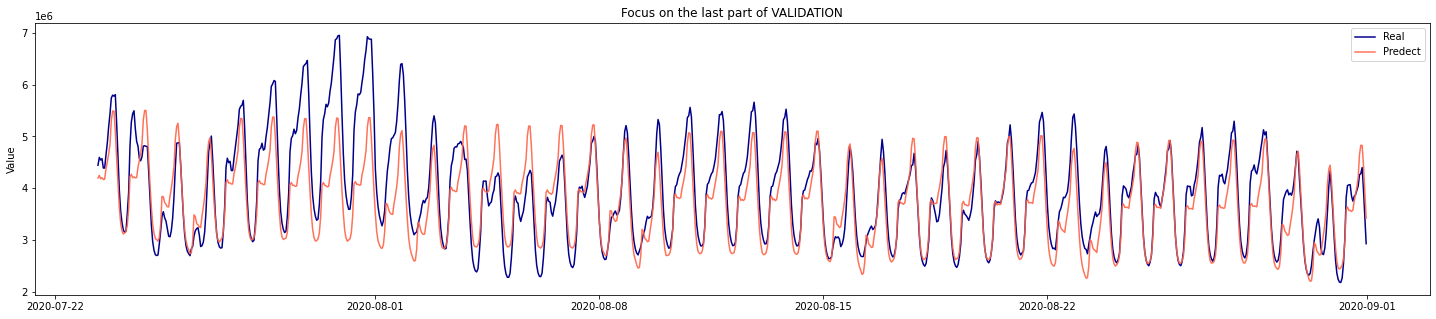

In [ ]:
plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min)

In [ ]:
model = sm.tsa.statespace.SARIMAX(train['Value'],
                                  order=(2, 0, 2), seasonal_order=(1, 1, 1, 24),
                                  exog=x_train,
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit(disp=0, low_memory=True)

In [ ]:
print(model.summary())

In [ ]:
fig = plt.figure(figsize=(20, 8))
fig = model.plot_diagnostics(fig=fig, lags=30)

Tutte le variabili utilizzate sono significative. I residui sono tra loro incorrelati come mostra il correlogramma. La distribuzione è normale a parte per la presenza di alcuni outliers che avevo già individuato all’inizio. Forse sarebbe opportuno aggiungere delle variabili dummy per modellare queste osservazioni.

# Previsioni

In [ ]:
#fourier's harmonics
four_sett = DeterministicProcess(pd.date_range(start="2018-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H'),  period=168, fourier=10)
four_ann = DeterministicProcess(pd.date_range(start="2018-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H'),  period=24*365.25, fourier=5)
four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

In [ ]:
x_data=four[:len(data)]
x_test=four[len(data):]

In [ ]:
model_tot = sm.tsa.statespace.SARIMAX(data['Value'],
                                  order=(2, 0, 2), seasonal_order=(1, 1, 1, 24),
                                  exog=x_data,
                                  enforce_stationarity=False, enforce_invertibility=False)
model_tot = model_tot.fit(low_memory=True)

In [ ]:
future = model_tot.get_prediction(start=pd.to_datetime('2020-09-01-0',  format = "%Y-%m-%d-%H"),
                              end=pd.to_datetime('2020-10-31-23',  format = "%Y-%m-%d-%H"),
                              exog=x_test)

In [ ]:
forecast = pd.DataFrame({'ARIMA':future.predicted_mean, 
                         'Date':pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H')})

In [ ]:
forecast.to_csv('ARIMA.csv')